In [44]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from scipy import stats
import time

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines

import warnings
warnings.filterwarnings('ignore')

In [45]:
root = "data\\2016\\"

winterMonths = ["01", "02", "11", "12"]
springMonths = ["03", "04", "05"]
summerMonths = ["06", "07", "08"]
fallMonths = ["09", "10"]


# TEMP...DELETE FOR FULL ANALYSIS
springMonths = ["03"]
summerMonths = ["06"]

In [46]:
def interestedColumns(df):
    interestedCols = ["taxi_id", "tolls", "trip_start_timestamp", "trip_end_timestamp", "company", "dropoff_centroid_longitude", \
        "dropoff_centroid_latitude", "fare", "payment_type", "pickup_centroid_latitude", "pickup_centroid_longitude", \
        "dropoff_community_area", "pickup_community_area", "tips", "trip_miles", "trip_seconds", "trip_total"]
    
    result = df[interestedCols]
    return(result)

In [47]:
def combineMonths(months):
    df = pd.DataFrame()
    
    for month in months:
        print("Working on", month)
        monthDir = join(root, month)
        filesList = [f for f in listdir(monthDir) if isfile(join(monthDir, f))]
        print("-- Found", len(filesList), "files")
        
        for file in filesList:
            print("----- Working on", file)
            filePath = join(monthDir, file)
            fileDf = pd.read_csv(filePath)
            fileDf = interestedColumns(fileDf)
            df = pd.concat([df, fileDf])  
            
        print("")
            
    print("***** Row Count:", len(df), "*****") 
    print("=============================================")            
    return(df)

In [48]:
#winterDf = combineMonths(winterMonths)
springDf = combineMonths(springMonths)
summerDf = combineMonths(summerMonths)
#fallDf = combineMonths(fallMonths)

Working on 03
-- Found 10 files
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000000000000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000000200000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000000400000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000000600000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000000800000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000001000000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000001200000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000001400000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000001600000.csv
----- Working on ChiTaxi_2016-03-01_2016-04-01_00000000000001800000.csv

***** Row Count: 1976333 *****
Working on 06
-- Found 10 files
----- Working on ChiTaxi_2016-06-01_2016-07-01_00000000000000000000.csv
----- Working on ChiTaxi_2016-06-01_2016-07-01_00000000000000200000.csv
----- Working on ChiTaxi_2016-06-01_2016

In [132]:
# i don't wanna work on the entire dataset. 
# taking a fraction only.

springFrac = springDf.head(500000).sample(frac = 0.001)
fallFrac = fallDf.head(500000).sample(frac = 0.001)

In [133]:
def convertDataType(df):    
    df["taxi_id"] = df["taxi_id"].astype("category")
    df["tolls"] = df["tolls"].astype("float").fillna(0.0)
    df["trip_start_timestamp"] = pd.to_datetime(df["trip_start_timestamp"], errors = "coerce").dt.strftime("%m/%d/%Y %I:%M %p")
    df["trip_end_timestamp"] = pd.to_datetime(df["trip_end_timestamp"], errors = "coerce").dt.strftime("%m/%d/%Y %I:%M %p")
    df["company"] = df["company"].astype("category")
    df["dropoff_centroid_longitude"] = df["dropoff_centroid_longitude"].astype("category")
    df["dropoff_centroid_latitude"] = df["dropoff_centroid_latitude"].astype("category")
    df["pickup_centroid_latitude"] = df["pickup_centroid_latitude"].astype("category")
    df["pickup_centroid_longitude"] = df["pickup_centroid_longitude"].astype("category")
    df["fare"] = df["fare"].astype("float").fillna(0.0)
    df["payment_type"] = df["payment_type"].astype("category")
    df["dropoff_community_area"] = df["dropoff_community_area"].astype("category")
    df["pickup_community_area"] = df["pickup_community_area"].astype("category")
    df["tips"] = df["tips"].astype("float").fillna(0.0)
    df["trip_miles"] = df["trip_miles"].astype("float").fillna(0.0)
    df["trip_seconds"] = df["trip_seconds"].astype("float").fillna(0.0)
    df["trip_total"] = df["trip_total"].astype("float").fillna(0.0)   
    return(df)

In [145]:
spring = convertDataType(springFrac)
fall = convertDataType(fallFrac)

In [146]:
def removeOutliers(seriesData):   
    seriesData = seriesData.astype(float).fillna(0.0)
    Q75, Q25 = np.percentile(seriesData, [75, 25])
    IQR = Q75 - Q25
    min = Q25 - (IQR * 1.5)
    max = Q75 + (IQR * 1.5)
    seriesData = np.array(seriesData)
    result = seriesData[np.where((seriesData >= min) & (seriesData <= max))]
    return(result)

In [147]:
def getECDF(seriesData):
    n = len(seriesData)
    x = np.sort(seriesData)
    y = np.arange(1, n + 1) / n
    return x, y

In [157]:
def buildECDF(df):
    for col in df:        
        colData = df[col]
        colDataType = colData.dtypes

        if (colDataType == "float64"):
            colData = removeOutliers(colData)
            x, y = getECDF(colData)
            _ = plt.plot(x, y, marker = ".", linestyle = "none")
            _ = plt.xlabel("Percent of " + col)
            _ = plt.ylabel("ECDF")
            _ = plt.title("ECDF of " + col)
            _ = plt.margins(0.02)
            _ = plt.show()        

In [164]:
def buildHistograms(df):
    for col in df:        
        colData = df[col]
        colDataType = colData.dtypes
        
        if (colDataType == "float64"):
            colData = removeOutliers(colData)
            
            _ = plt.hist(colData, bins = 30)
            _ = plt.xlabel(col)
            _ = plt.ylabel("Occurences")
            _ = plt.title("Histogram of " + col)
            _ = plt.show()
        

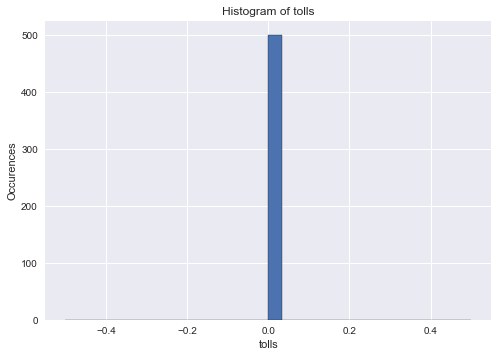

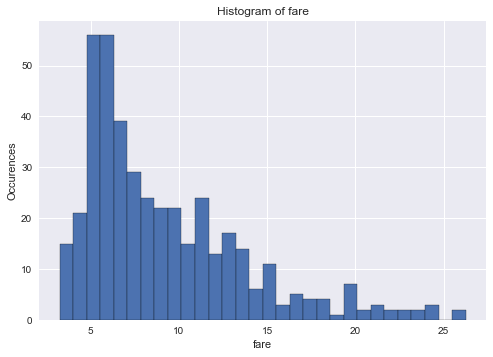

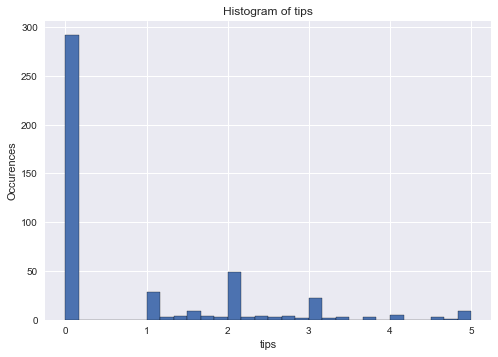

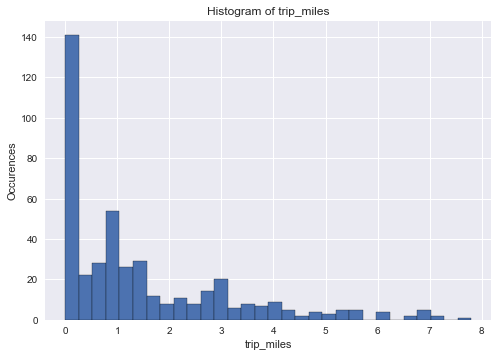

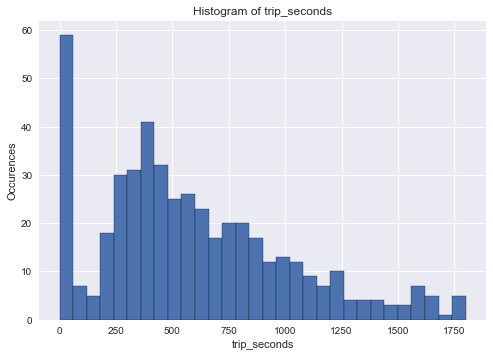

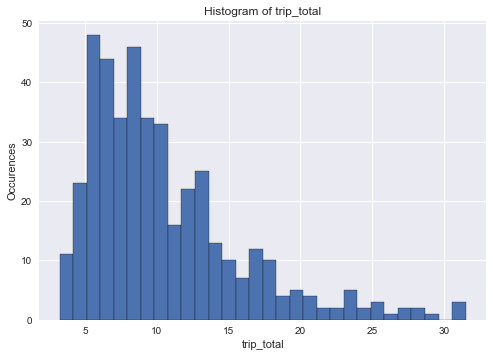

In [165]:
buildHistograms(spring)

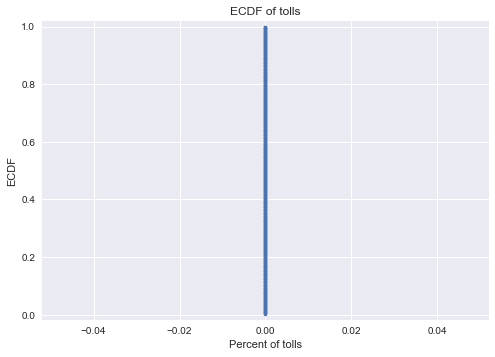

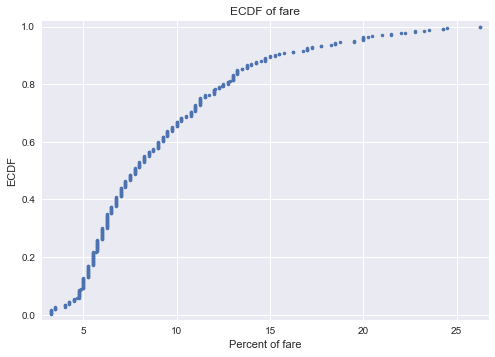

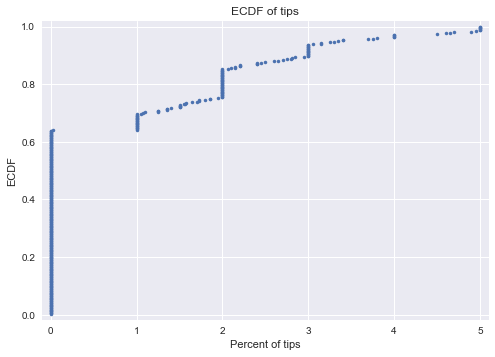

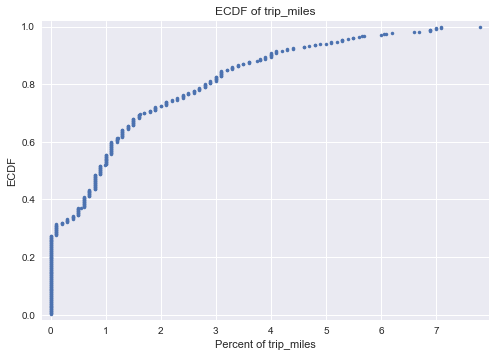

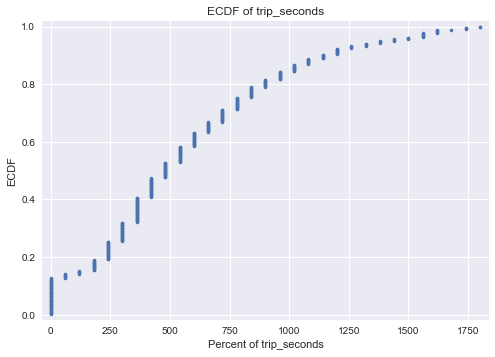

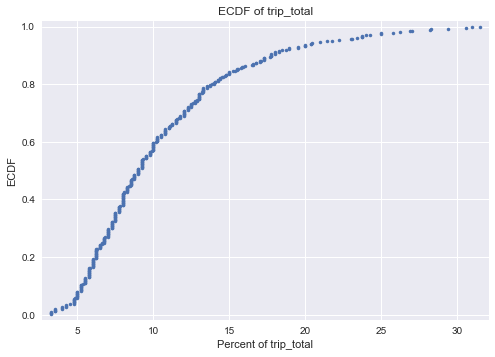

In [166]:
buildECDF(spring)

In [173]:
def getCorr(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

In [177]:
getCorr(spring["trip_total"], spring["trip_seconds"])

0.70460561386533671

In [178]:
getCorr(spring["fare"], spring["trip_seconds"])

0.74877278757829857

In [182]:
getCorr(spring["tips"], spring["trip_seconds"])

0.28940469666106233

In [184]:
spring.head()

,taxi_id,tolls,trip_start_timestamp,trip_end_timestamp,company,dropoff_centroid_longitude,dropoff_centroid_latitude,fare,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_community_area,pickup_community_area,tips,trip_miles,trip_seconds,trip_total
94178,27f5b756c311dcd074c7388c5c63b995cab41758a87cb9...,0.0,03/08/2016 06:45 PM,03/08/2016 07:15 PM,NaN,-87.620993,41.884987,32.00,Credit Card,41.785999,-87.750934,32.0,56.0,7.20,12.1,1560.0,43.20
73790,d688e9313aeb18ae082faf7e34b5b177eb7b94066d5787...,0.0,03/02/2016 09:45 AM,03/02/2016 09:45 AM,Blue Ribbon Taxi Association Inc.,NaN,NaN,7.75,Cash,NaN,NaN,NaN,NaN,0.00,0.0,540.0,7.75
83350,a5d9c93d039ac07f8a974c7877a39763415ff828c79839...,0.0,03/05/2016 04:00 AM,03/05/2016 04:15 AM,NaN,-87.659167,41.809018,22.75,Cash,41.899602,-87.633308,61.0,8.0,0.00,8.7,780.0,23.75
191868,63949ba2d780a63de1b6353ff7ad8a49ee5854e8c5c65e...,0.0,03/07/2016 12:30 AM,03/07/2016 12:30 AM,KOAM Taxi Association,-87.625192,41.878866,7.50,Credit Card,41.899602,-87.633308,32.0,8.0,0.00,1.5,420.0,8.50
41214,9339a036614999c0d222dfbfba07e4f256853f43232095...,0.0,03/07/2016 08:15 PM,03/07/2016 08:15 PM,Taxi Affiliation Services,-87.685362,41.928619,14.75,Credit Card,41.880994,-87.632746,22.0,32.0,2.95,4.8,720.0,17.70


#### QUESTIONS:
- Which company earns more?
- What is the optimal time to drive?
- Where do most pickups occur? (for each season)
- Where do most dropoffs occur? (for each season)
- Do credit cards tip more than cash?
- For pickups/dropoffs, which locations generate the most revenue? (for each season)
- Do we see a dip/spike in trips based on weather?
- Do higher socioeconomic areas request more pickups?
- Can we predict the tip based on pickup and dropoff point?
- What is the spatial autocorrelation between socioeconomic location and tip?
- Do taxi pickups occur more/less around bus-stops?
- Do taxi pickups occur more/less around divy stops? (spring/summer/fall)
- Number of taxi trips by day (check against the holidays)